First we load back the Pre-Detrended Data from the first Notebook.

In [2]:
import numpy as np
NPZ = np.load("Example Data/Pre_detrended.npz")

Time = NPZ.get("Time")
Flux = NPZ.get("Flux")
FeatureMask = NPZ.get("FeatureMask")

Now we prepare the Iterative detrending algorithm which will use the Generalized Lomb Scargle Periodogramm as written by Zechmeister and Kürster.

In [3]:
from PyAstronomy.pyTiming import pyPeriod
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt


In [4]:
#Prepare the Frequency grid on which the Periodogram is calculated
periods = np.logspace(np.log10(0.25),np.log10(30),1000)*u.d 
frequency = 1/periods

flx = Flux[FeatureMask]
tme = Time[FeatureMask]

Flux_Rep = flx.copy() #Copy of the Flux for iterative subtracting of the fits  without changing the original Pre Detrended Flux
Flux_Features = Flux.copy() # Copy of the Flux with Features so we get a detrended view of the features at the end.

#Preparation of the Table which stores the different Parameters for each 
tbl_Detrend = Table(names=["Period","P_err","Amplitude","A_err","T0","T0_err","off","off_err","Probability","False Alarm Probability"],units=[u.d,u.d,u.electron/u.s,u.electron/u.s,u.d,u.d,u.electron/u.s,u.electron/u.s,1,1]) #Table
    


FalseAlarmFlag = False #Flag for stopping the loop once we have reached the threashold that the max of the periodogram is under the false alarmlevel
FAP_Stop = 0.5 # The False Alarm Probabiliy at which the Iterative detrending Algorithm Stops

Powers = []
Fluxes = [Flux_Rep] #List that Tracks the Fluxes from the Start, includes the undetrended Flux so Power[0] is the Corresponding Periodogram to Fluxes[0]
FAP_Levels = []
Sines = []

i = 0
while FalseAlarmFlag == False:
    
    
    #Create Lomb Scargle Periodogram Class
    clp = pyPeriod.Gls((tme,Flux_Rep), freq = frequency.value,norm="ZK") #Calculates GLS 

    Periodogram = clp.power # Calculate the Power of the Lomb Scargle Periodogram
    idx = np.argmax(Periodogram) #Find Index of Strongest Power
    p_rep = periods[idx] #Corresponding Period of the Strongest Signal
    


    y_fit = clp.sinmod(tme) # Gives the Fitted Sinus curve to the Variability
    Flux_Rep = Flux_Rep - y_fit # Detrend with the Fit
    Flux_Features -= clp.sinmod(Time) #Detrend the Time Series with Masked out outliers
    
    FAP = clp.FAP(Periodogram[idx])#Get the FAP of the Maximum
    
    Powers.append(Periodogram)
    Sines.append(y_fit)
    Fluxes.append(Flux_Rep)

    #Extract all the necessary parameters from the computed Periodogram which can be used to calculate the fitted sinus.
    amp = clp.hpstat["amp"]
    pe = p_rep*clp.hpstat["f_err"]/clp.hpstat["fbest"]
    Ae = clp.hpstat["amp_err"]
    T0 = clp.hpstat["T0"]
    T0e = clp.hpstat["T0_err"]
    off = clp.hpstat["offset"]
    offe = clp.hpstat["offset_err"]
    
    
    tbl_Detrend.add_row([p_rep,pe,amp,Ae,T0,T0e,off,offe,Periodogram[idx],FAP])
    
    FAP_Power = clp.powerLevel(FAP_Stop) #Get the Probbility of the Periodogram corresponding to the False alarm Porbability set in FAP_Stop
    FAP_Levels.append(FAP_Power)

    # Break Condition strongest signal is below a FAP of 0.5
    if FAP_Power > Periodogram[idx]:
        FalseAlarmFlag = True
        

    i += 1

Powers = np.array(Powers)
Fluxes = np.array(Fluxes)
FAP_Levels = np.array(FAP_Levels)
Sines = np.array(Sines)

We plot the Iterative detrending with some examples of the Iteration and the end result. The End result will additionaly be shown with a rolling median overplotted which can  

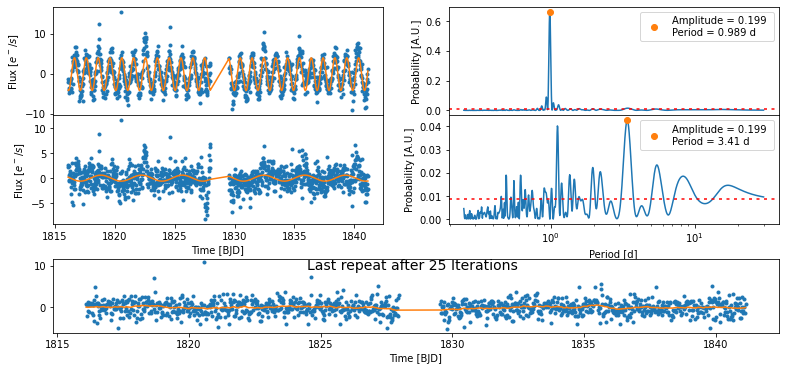

In [5]:
n_single = 2 # How many Iteration Steps are plotted

#Figure
fig = plt.figure(constrained_layout = False,figsize=(13,2*(n_single+1)))
gs1 = fig.add_gridspec(nrows=n_single+1, ncols=2, wspace=0.20,hspace=0.0)
gs2 = fig.add_gridspec(nrows=n_single+1, ncols=2, hspace=0.7)



ax_right = []
ax_left = []
for i in range(n_single):
  
    a = fig.add_subplot(gs1[i,0])
    b=fig.add_subplot(gs1[i,1])
    ax_left.append(a)
    ax_right.append(b)
    


axbig = fig.add_subplot(gs2[n_single,:])

for i in range(n_single):

    Periodogram = Powers[i]
    Detrended = Fluxes[i]
    idx = np.argmax(Periodogram)

    ax_right[i].plot(periods,Periodogram)
    ax_right[i].plot(periods[idx],Periodogram[idx],"o",label=f"Amplitude = {amp:.3} \nPeriod = {periods[idx]:.3}")
    ax_right[i].axhline(FAP_Levels[i],dashes=(2,3),color="r")
    ax_right[i].legend()
    ax_right[i].semilogx()

    ax_left[i].plot(tme,Detrended,".")
    ax_left[i].plot(tme,Sines[i])


for ax in ax_left:
    ax.set(ylabel="Flux [$e^-/s$]")

for ax in ax_right:
    ax.set(ylabel="Probability [A.U.]")

for ax in ax_left[:-1]:
    ax.set_xticks([])

ax_left[n_single-1].set(xlabel="Time [BJD]")
ax_right[n_single-1].set(xlabel="Period [d]")


N = 50
trend_lc = np.convolve(Flux_Features, np.ones((N,))/N, mode='same')#Calculate a Rolling Average to Check the Las

axbig.plot(Time,Flux_Features,".")
axbig.plot(Time[~FeatureMask],Flux_Features[~FeatureMask],"r.")
axbig.plot(Time,trend_lc,"-")
axbig.text(0.35,0.85,f"Last repeat after {tbl_Detrend.__len__()} Iterations",transform=axbig.transAxes,fontsize=14)
axbig.set(xlabel="Time [BJD]")
plt.show()

We can observe here that the Iterative detrending does remove most of the Periodicities additionaly we can see that the first mode which is found can be seen definetely in the Data. Now we want to confirm if most or all of the signals are extracted from the Data. We do check this by plotting the autocorrelation of the Original pre-detrended data and the post iterative detrended data.

Text(0.5, 0.98, 'Autocorrelation')

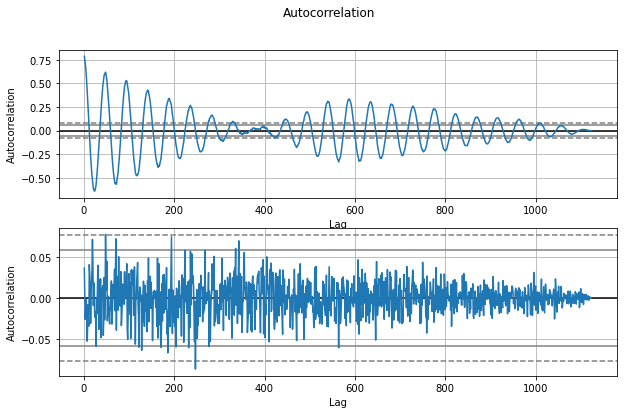

In [6]:
import pandas as pd

fig, ax = plt.subplots(2,1,figsize=(10,6))

#Use Pandas Plotting function to Calculate the autocorrelation
pd.plotting.autocorrelation_plot(flx,ax[0])
pd.plotting.autocorrelation_plot(Fluxes[-1],ax[1])
fig.suptitle("Autocorrelation")

Lastly we also check for the Trends of the Periods and for changing periods with the help of a wavelet transform.

d:\productivity\anaconda\envs\bachelor\lib\site-packages\wavelets\transform.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wavelet_data[slices],


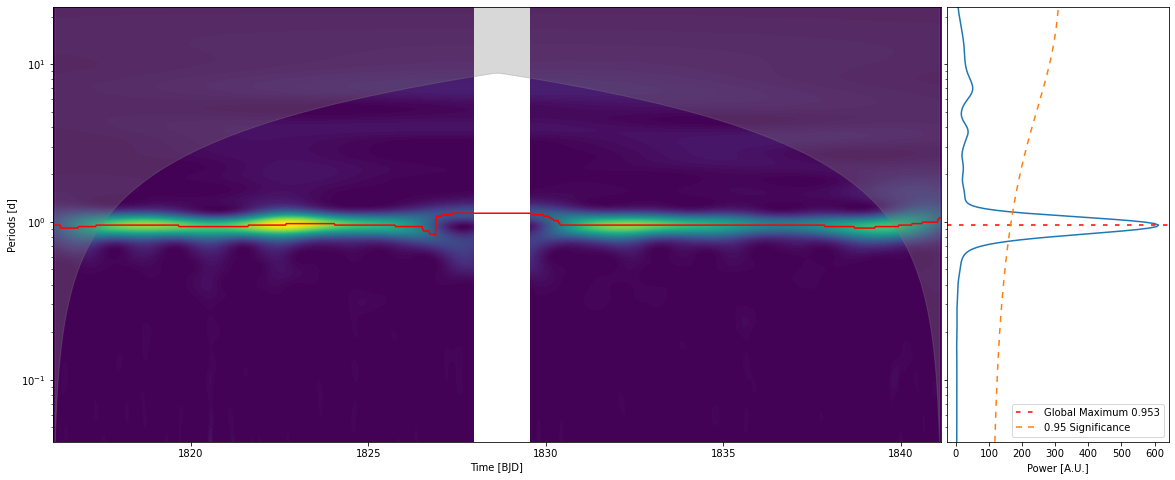

In [7]:
from wavelets import WaveletAnalysis
import pycwt

#Calculate the difference between two time masks
dt = Time[1] - Time[0]
wa = WaveletAnalysis(Flux[FeatureMask], time = Time[FeatureMask] ,dt=dt,dj=2**-5)#,wavelet=w.Ricker())

# wavelet power spectrum
power = wa.wavelet_power

# scales 
scales = wa.scales

# associated time vector
t = wa.time

# reconstruction of the original data
rx = wa.reconstruction()    

global_mean = np.mean(power,axis=1) # Create Global Spectrum by meaning over
global_max = scales[global_mean.argmax()] #Calculate the Global Maximum

#Time max series:
max_per_time = scales[np.argmax(power,axis=0)]

#### Calculate Significance Bound 0.95
alpha,_,_ = pycwt.ar1(Flux[FeatureMask])
N = Flux[FeatureMask].size
dof = N-scales
signif,_ = pycwt.significance(Flux[FeatureMask],dt,scales,1,alpha,dof=dof)#,wavelet=pycwt.mothers.DOG())



T, S = np.meshgrid(t, scales) # Create T S Meshgrid for Plotting

#This is used to find the TESS Gap and mask it out so it appears as a white space at the time where no data is taken. 
check = np.diff(Time)
ind = np.argwhere(check > 2/24)
HMask = np.zeros_like(T,dtype=bool)
for i in ind:
    m = (T>Time[i]) & (T<Time[i+2])
    HMask = np.bitwise_or(HMask,m)


fig, ax = plt.subplots(1,2,sharey=True,figsize=(20,8),gridspec_kw=dict(width_ratios=[0.8,0.2]))
fig.subplots_adjust(wspace=0.01)

cf =ax[0].contourf(T, S, np.ma.array(power,mask=HMask), 100)
ax[0].set_yscale('log')
ax[0].set_ylabel("Periods [d]")
ax[0].set_xlabel("Time [BJD]")
ax[0].plot(t,max_per_time,"r")
ax[1].plot(global_mean,scales)
ax[1].axhline(global_max,dashes=(3,5),color="r",label=f"Global Maximum {global_max:.3}")
ax[1].plot(signif,scales,dashes=(4,4),label="0.95 Significance")
ax[1].set_xlabel("Power [A.U.]")
ax[1].legend()

coix, coiy = wa.coi
ax[0].fill_between(x=coix, y1=coiy, y2=scales.max(), color='gray', alpha=0.3)
plt.show()

We then save the Table in which the retrieved Periods and other fit parameters were saved and then go to the last step the  Selection of the Modes.

In [8]:
DF = tbl_Detrend.to_pandas()
DF.to_csv("Example Data/Periods.csv")